# module imports and data preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install tensorflow==2.11.1

import tensorflow as tf
print(tf.__version__)
# tensorflow version used at development was 2.11.1, tf_io version: 0.31.0, tfp version: 0.19.0
# tensorflow on google colab upgraded to 2.12.0 at March 30. 2023, in middle of this project
# which introduced some compatibility issues, fixing the version at 2.11.1 have no issues.

import torch
print(torch.__version__)
import matplotlib
print(matplotlib.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-serve

In [3]:
# Other imports
! pip install tensorflow_addons==0.19.0
! pip install tensorflow_io==0.31.0
! pip install tensorflow_probability==0.19.0
! pip install porespy==2.2.2

import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
# import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_hub as hub
import tensorflow_probability as tfp

import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from scipy import interpolate
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity as cos
from sympy.utilities.iterables import multiset_permutations
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, roc_auc_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity as kde
from IPython.display import Image, display
import porespy
from edt import edt

tfpl = tfp.layers
tfd = tfp.distributions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.32.0
    Uninstalling tensorflow-io-gcs-filesystem-0.32.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.32.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Define model functions and image preprocessing functions

## image preprocessing functions

In [4]:
# Image preprocessing utils
def parse_images_saxs(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[sem_imageSize, sem_imageSize])

    return image

In [5]:
# Image preprocessing utils
def parse_images_saxs_for_mapping_tf_ds(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[sem_imageSize, sem_imageSize])

    return image, image

In [6]:
# Image preprocessing utils
def parse_images_sem_TSNE(image_path):
    image_string = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image_string)[:, :, :3]   # in the doc, it transforms tiff to 4 channels, with additional channel of opacity which is not needed.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image[:sem_original_x_length, :sem_original_y_length, :]
    image = image[:sem_imageSize, :sem_imageSize, :]

    return image

In [7]:
# Image preprocessing utils
def parse_images_sem_no_crop(image_path):
    image_string = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image_string)[:, :, :3]   # in the doc, it transforms tiff to 4 channels, with additional channel of opacity which is not needed.
    image = image[:sem_original_x_length, :sem_original_y_length, :]
    image = tfa.image.gaussian_filter2d(image, 5)
    image = cv2.cvtColor(image.numpy().astype('float32'), cv2.COLOR_BGR2GRAY)
    image = cv2.adaptiveThreshold(image.astype('uint8'), 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, adapt_window, 2)
    image = cv2.GaussianBlur(image,(5,5),0)

    return image

In [8]:
# Image preprocessing utils
def parse_images_sem_crop(image_path, left, bottom):
    image_string = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image_string)[:, :, :3]   # in the doc, it transforms tiff to 4 channels, with additional channel of opacity which is not needed.
    image = image[:sem_original_x_length, :sem_original_y_length, :]
    image = tfa.image.gaussian_filter2d(image, 5)
    image = cv2.cvtColor(image.numpy().astype('float32'), cv2.COLOR_BGR2GRAY)
    image = cv2.adaptiveThreshold(image.astype('uint8'), 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, adapt_window, 2)
    image = cv2.GaussianBlur(image,(5,5),0)
    image = image[left:left+sem_imageSize, bottom:bottom+sem_imageSize]

    return image

In [9]:
# Image preprocessing utils
def parse_images_sem_crop_tf_ds(image, left, bottom):
    # left = 0
    # bottom = 0
    image = image[left:left+sem_imageSize, bottom:bottom+sem_imageSize, :]
    image_2d = image[:, :, 0]

    return image, image_2d

## functions for vae model building

In [10]:
%cd "/content/drive/MyDrive/nanowire-morphology-classification-project"

/content/drive/.shortcut-targets-by-id/1qb_BrPe6oJ2Dg0E6xoFYETWtLHETrwQj/nanowire-morphology-classification-project


In [11]:
def upsample(filters, size, apply_dropout=False):

  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    bias_initializer='he_normal'))

  result.add(BatchNormalization())

  if apply_dropout:
      result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [12]:
# define loss functions and metrics for segmentation task
# coef functions are for batches of images, score functions are for a single image

def dice_coef_2d(y_true, y_pred, smooth=0.000001):
  
    beta = 1
    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    fp = tf.reduce_sum(y_pred, axis=[1,2]) - tp
    fn = tf.reduce_sum(y_true, axis=[1,2]) - tp

    score = tf.reduce_mean(((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth))
    return score

def dice_coef_3d(y_true, y_pred, smooth=0.000001):
  
    beta = 1
    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    fp = tf.reduce_sum(y_pred, axis=[1,2,3]) - tp
    fn = tf.reduce_sum(y_true, axis=[1,2,3]) - tp

    score = tf.reduce_mean(((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth))
    return score

def dice_score(y_true, y_pred, smooth=0.000001):
  y_true = y_true.astype('float32')
  y_pred = y_pred.astype('float32')
  beta = 1
  tp = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
  fp = tf.reduce_sum(y_pred, axis=[1, 2]) - tp
  fn = tf.reduce_sum(y_true, axis=[1, 2]) - tp

  score = tf.reduce_mean(((1 + beta ** 2) * tp + smooth) \
          / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)).numpy()
  return score

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=0.000001):

    beta = 1
    tp = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    fp = tf.reduce_sum(y_pred, axis=[1,2]) - tp
    fn = tf.reduce_sum(y_true, axis=[1,2]) - tp

    score = tf.reduce_mean((tp + smooth) \
            / (tp + fn + fp + smooth))
    return score

def iou_score(y_true, y_pred, smooth=0.000001):
  y_true = y_true.astype('float32')
  tp = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
  fp = tf.reduce_sum(y_pred, axis=[1, 2]) - tp
  fn = tf.reduce_sum(y_true, axis=[1, 2]) - tp

  score = tf.reduce_mean((tp + smooth) \
          / (tp + fn + fp + smooth)).numpy()
  return score

def iou_coef_loss(y_true, y_pred):
    return 1 - iou_coef(y_true, y_pred)

negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

def softmax_loss(y_true, y_pred):
  softmax_loss = tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred, axis=[1, 2, 3])
  return softmax_loss

In [13]:
def saxs_encoder(shape, feature_extractor_model, num_features, prior, kl_weight):
  inputs = Input(shape)

  x = feature_extractor_model(inputs)

  x = Dense(num_features, activation='relu', kernel_initializer='random_normal')(x)
  
  # x = AveragePooling2D((2,2))(x)

  encoded_size = x.shape[-1]
  
  # options for distribution: IndependentNormal or MultivariateNormalTriL
  x = Dense(tfpl.IndependentNormal.params_size(encoded_size), activation=None)(x)
  x = tfpl.IndependentNormal(encoded_size, activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=kl_weight))(x)
  return Model(inputs=inputs, outputs=x)

In [14]:
def saxs_decoder(shape, num_filter, filter_size):
  inputs = Input(shape)

  x = inputs

  upsampling_block = [
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    # upsample(num_filter, filter_size),
  ]

  # x = Reshape((1, 1, x.shape[-1]))(x)

  for up in upsampling_block:
    x = up(x)
  
  last = Conv2DTranspose(3, filter_size,    # number of class, size of input vector (batch_size, x, y, class)
                              strides=2,
                              padding='same',
                              bias_initializer='he_normal',
                              kernel_initializer='he_normal',
                              activation='sigmoid')       # (batch_size, resolution, resolution, 3)
                              # sigmoid activation transforms values to between 0 and 1
  
  x = last(x)
  # Bernoulli distribution for the recreated image, for it's binary. () means we don't want the third dimension. We want (imageSize, imageSize)
  # x = tfpl.IndependentBernoulli((), convert_to_tensor_fn=tfd.Distribution.mode)(x)

  return Model(inputs=inputs, outputs=x)

In [15]:
def sem_encoder(shape, feature_extractor_model, num_features, prior, kl_weight):
  inputs = Input(shape)

  x = feature_extractor_model(inputs)

  x = Dense(num_features, activation='relu', kernel_initializer='random_normal')(x)
  
  # x = AveragePooling2D((2,2))(x)

  encoded_size = x.shape[-1]
  
  # options for distribution: IndependentNormal or MultivariateNormalTriL
  x = Dense(tfpl.IndependentNormal.params_size(encoded_size), activation=None)(x)
  x = tfpl.IndependentNormal(encoded_size, activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=kl_weight))(x)
  return Model(inputs=inputs, outputs=x)

In [16]:
def sem_decoder(shape, num_filter, filter_size):
  inputs = Input(shape)

  x = inputs

  upsampling_block = [
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    upsample(num_filter, filter_size),
    # upsample(num_filter, filter_size),
  ]

  # x = Reshape((1, 1, x.shape[-1]))(x)

  for up in upsampling_block:
    x = up(x)
  
  last = Conv2DTranspose(num_filter, filter_size,    # size of input vector (batch_size, x, y, num_filter)
                              strides=2,
                              padding='same',
                              bias_initializer='he_normal',
                              kernel_initializer='he_normal',
                              activation=None)
                              # no activation here because we are use logits directly in the Bernoulli layer, 
                              # and the Bernoulli layer will act as an activation layer
  
  x = last(x)
  x = tf.reduce_mean(x, axis=-1, keepdims=True)

  # Bernoulli distribution for the recreated image, for it's binary. () means we don't want the third dimension. We want (imageSize, imageSize)
  x = tfpl.IndependentBernoulli((), convert_to_tensor_fn=tfd.Distribution.mode)(x)

  return Model(inputs=inputs, outputs=x)

In [17]:
def get_pretrained_image_encoder_model(Resnet50_backbone, imagesize, hidden_1, hidden_2, hidden_3):
    base_model = Resnet50_backbone
    base_model.trainable = True
    inputs = Input((imagesize, imagesize, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)                                        
    projection_1 = Activation("relu")(projection_1)
    projection_1 = BatchNormalization(epsilon=0.001)(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_2 = BatchNormalization(epsilon=0.001)(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)
    projection_3 = BatchNormalization(epsilon=0.001)(projection_3)

    resnet_model = Model(inputs, projection_3)
    
    return resnet_model

# hyperparameters

In [18]:
training_batch_size = 8

# cropped image size for both saxs and sem images
saxs_imageSize = 192
sem_imageSize = 192

# size of the latent space for both autoencoders
latent_space_num_filters = 32

# sem image without the bottom part
sem_original_x_length = 830
sem_original_y_length = 1280

# window size for adaptive thresholding
adapt_window = 15

# pair vae training hyperparameters
method = 'barlow'

sim_weight = 5e-3
saxs_saxs_weight = 4e-2
saxs_sem_weight = 4e-1
sem_sem_weight = 4e-2
sem_saxs_weight = 1e0

# initiate trained SAXS and SEM VAE model and load SAXS and SEM images

In [19]:
Resnet50_transfer_sem = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(sem_imageSize, sem_imageSize, 3), 
    pooling=None,
)

Resnet50_transfer_saxs = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(saxs_imageSize, saxs_imageSize, 3), 
    pooling=None,
)

Resnet50_transfer_sem.trainable = False
Resnet50_transfer_saxs.trainable = False

In [20]:
num_filter = 8
filter_size = 5
prior_mean = 0
prior_variance = 1
saxs_kl_weight = 1e-6

encoder_res = np.array([512])
encoder_batch_size = np.array([8])
random_seed_list = np.array([45])

In [21]:
# this is the training block of vae_encoder and vae_decoder
resnet_model = get_pretrained_image_encoder_model(Resnet50_transfer_saxs, saxs_imageSize, 128, 64, 1024)
if encoder_res[0] == 224:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_seed%i.h5' % (encoder_batch_size[0], random_seed_list[0]))
else:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_res%i_seed%i.h5' % (encoder_batch_size[0], encoder_res[0], random_seed_list[0]))
trained_resnet50 = resnet_model.get_layer('resnet50')
trained_resnet50.trainable = False

saxs_encoded_size = [saxs_imageSize // 32, saxs_imageSize // 32, latent_space_num_filters]

# gaussian distribution as the prior distribution for the encoded latent space
saxs_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(saxs_encoded_size) + prior_mean, scale=prior_variance), reinterpreted_batch_ndims=1)

vae_saxs_encoder = saxs_encoder((saxs_imageSize, saxs_imageSize, 3), trained_resnet50, latent_space_num_filters, saxs_prior, saxs_kl_weight)

vae_saxs_decoder = saxs_decoder(saxs_encoded_size, num_filter, filter_size)

saxs_vae = Model(inputs=vae_saxs_encoder.inputs, outputs=vae_saxs_decoder(vae_saxs_encoder.outputs[0]))

In [22]:
num_filter = 32
filter_size = 15
prior_mean = 0
prior_variance = 1
sem_kl_weight = 1e-6

encoder_res = np.array([512])
encoder_batch_size = np.array([8])
random_seed_list = np.array([45])

In [23]:
# this is the training block of vae_encoder and vae_decoder
resnet_model = get_pretrained_image_encoder_model(Resnet50_transfer_sem, sem_imageSize, 128, 64, 1024)
if encoder_res[0] == 224:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_seed%i.h5' % (encoder_batch_size[0], random_seed_list[0]))
else:
  resnet_model.load_weights('barlow_resnet_batch%i_project128_64_1024_res%i_seed%i.h5' % (encoder_batch_size[0], encoder_res[0], random_seed_list[0]))
trained_resnet50 = resnet_model.get_layer('resnet50')
trained_resnet50.trainable = False

sem_encoded_size = [sem_imageSize // 32, sem_imageSize // 32, latent_space_num_filters]

# gaussian distribution as the prior distribution for the encoded latent space
sem_prior = tfd.Independent(tfd.Normal(loc=tf.zeros(sem_encoded_size) + prior_mean, scale=prior_variance), reinterpreted_batch_ndims=1)

vae_sem_encoder = sem_encoder((sem_imageSize, sem_imageSize, 3), trained_resnet50, latent_space_num_filters, sem_prior, sem_kl_weight)

vae_sem_decoder = sem_decoder(sem_encoded_size, num_filter, filter_size)

sem_vae = Model(inputs=vae_sem_encoder.inputs, outputs=vae_sem_decoder(vae_sem_encoder.outputs[0]))

In [24]:
sem_image_path = "/content/drive/MyDrive/TEM image datasets/2023-Sci-Adv-SAXS-SEM/SEM"
sem_image_file_list = list(paths.list_files(basePath=sem_image_path, validExts='tif'))
sem_image_file_list.sort()
sem_image_file_list = np.array(sem_image_file_list)
saxs_image_path = "/content/drive/MyDrive/TEM image datasets/2023-Sci-Adv-SAXS-SEM/SAXS"
saxs_image_file_list = list(paths.list_files(basePath=saxs_image_path, validExts='jpg'))
saxs_image_file_list.sort()
saxs_image_file_list = np.array(saxs_image_file_list)

sem_image_holder = np.zeros((len(sem_image_file_list), sem_imageSize, sem_imageSize, 3))
sem_image_2d_holder = np.zeros((len(sem_image_file_list), sem_imageSize, sem_imageSize))
saxs_image_holder = np.zeros((len(saxs_image_file_list), saxs_imageSize, saxs_imageSize, 3))
for i in range(len(saxs_image_file_list)):
        saxs_image_holder[i] = parse_images_saxs(saxs_image_file_list[i])

# Model performance assessment: 5 models trained with different selections of training images, and with 10 random SEM crops to look at 2-point correlation functions true vs. reconstructed

In [ ]:
train_ratio = np.array([4/9, 6/9, 8/9])
train_size = np.rint(len(sem_image_file_list) * train_ratio).astype(int)
train_size_legend = np.arange(len(train_ratio))

mother_directory = '/content/drive/MyDrive/ML projects/SAXS_SEM/performance_assessment/'

hyperparameter_tuning_result = {}
for i in range(len(train_ratio)):
  save_file_name = 'cropSize%i_windowSize%i_latentSize%i_trainSize%i' \
    % (saxs_imageSize, adapt_window, latent_space_num_filters, train_size[i])
  y = np.load(mother_directory + 'solo_vae_' + save_file_name + '.npz', allow_pickle=True)
  hyperparameter_tuning_result.update({'solo_train_size%i' % (train_size[i]): y})
  y = np.load(mother_directory + 'pair_vae_' + save_file_name + '.npz', allow_pickle=True)
  hyperparameter_tuning_result.update({'pair_train_size%i' % (train_size[i]): y})

solo_saxs = [np.reshape(hyperparameter_tuning_result['solo_train_size%i' % (train_size[i])]['saxs_mae'], -1) for i in train_size_legend]
pair_saxs_saxs = [np.reshape(hyperparameter_tuning_result['pair_train_size%i' % (train_size[i])]['saxs_saxs_mae'], -1) for i in train_size_legend]
pair_sem_saxs = [np.reshape(hyperparameter_tuning_result['pair_train_size%i' % (train_size[i])]['sem_saxs_mae'], -1) for i in train_size_legend]
solo_sem = [np.reshape(hyperparameter_tuning_result['solo_train_size%i' % (train_size[i])]['sem_mae'], -1) for i in train_size_legend]
pair_sem_sem = [np.reshape(hyperparameter_tuning_result['pair_train_size%i' % (train_size[i])]['sem_sem_mae'], -1) for i in train_size_legend]
pair_saxs_sem = [np.reshape(hyperparameter_tuning_result['pair_train_size%i' % (train_size[i])]['saxs_sem_mae'], -1) for i in train_size_legend]

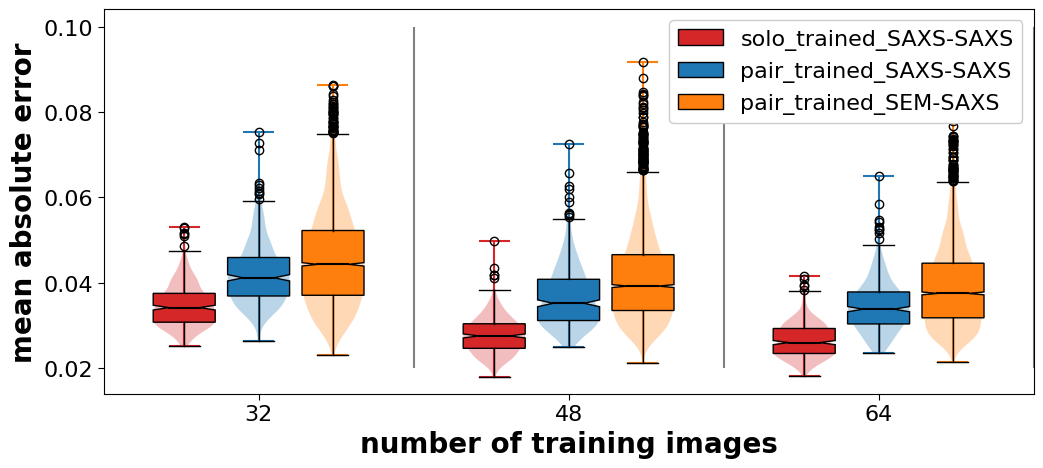

In [ ]:
box_width = 0.2
shift = 0.4
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors[3:4] + plt.cm.tab10.colors[0:3] + plt.cm.tab10.colors[4:5])    # avoid having both green and red in the same boxplot format
color_method = ['C0', 'C1', 'C2', 'C3', 'C4']

# plot the scores versus different models and data percentages
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

plt.violinplot(solo_saxs, widths=box_width, positions=np.arange(1, 4) - shift * 0.6)
box0 = plt.boxplot(solo_saxs, widths=box_width, positions=np.arange(1, 4) - shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[0]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot(pair_saxs_saxs, widths=box_width, positions=np.arange(1, 4) + shift * 0)
box1 = plt.boxplot(pair_saxs_saxs, widths=box_width, positions=np.arange(1, 4) + shift * 0, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot(pair_sem_saxs, widths=box_width, positions=np.arange(1, 4) + shift * 0.6)
box2 = plt.boxplot(pair_sem_saxs, widths=box_width, positions=np.arange(1, 4) + shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[2]), medianprops=dict(color="black",linewidth=1.5))

for i in range(3):
  ax.vlines(1.5 + i, 0.02, 0.10, colors='grey')
ax.set_xticks((train_size_legend + 1))
ax.set_xticklabels(train_size)
ax.set_xlim(0.5, 3.5)
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'number of training images', fontsize=20, fontweight='bold')
ax.set_ylabel(r'mean absolute error', fontsize=20, fontweight='bold')
ax.legend([box0["boxes"][0], box1["boxes"][0], box2["boxes"][0]], ['solo_trained_SAXS-SAXS', 'pair_trained_SAXS-SAXS', 'pair_trained_SEM-SAXS'], fontsize=16, loc='upper right', framealpha=1)

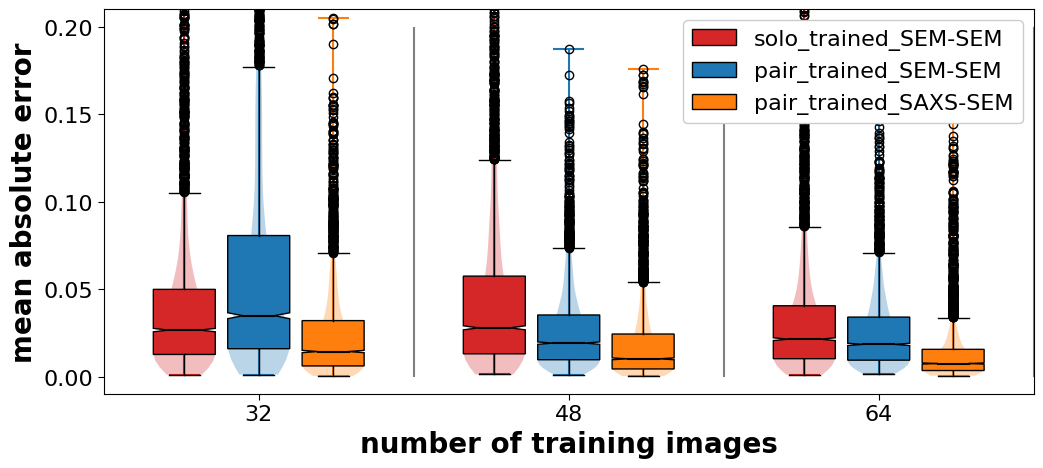

In [ ]:
box_width = 0.2
shift = 0.4
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors[3:4] + plt.cm.tab10.colors[0:3] + plt.cm.tab10.colors[4:5])    # avoid having both green and red in the same boxplot format
color_method = ['C0', 'C1', 'C2', 'C3', 'C4']

# plot the scores versus different models and data percentages
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

plt.violinplot(solo_sem, widths=box_width, positions=np.arange(1, 4) - shift * 0.6)
box0 = plt.boxplot(solo_sem, widths=box_width, positions=np.arange(1, 4) - shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=(color_method[0])), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot(pair_sem_sem, widths=box_width, positions=np.arange(1, 4) + shift * 0)
box1 = plt.boxplot(pair_sem_sem, widths=box_width, positions=np.arange(1, 4) + shift * 0, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[1]), medianprops=dict(color="black",linewidth=1.5))

plt.violinplot(pair_saxs_sem, widths=box_width, positions=np.arange(1, 4) + shift * 0.6)
box2 = plt.boxplot(pair_saxs_sem, widths=box_width, positions=np.arange(1, 4) + shift * 0.6, notch=True, patch_artist=True, boxprops=dict(facecolor=color_method[2]), medianprops=dict(color="black",linewidth=1.5))

for i in range(3):
  ax.vlines(1.5 + i, 0.0, 0.20, colors='grey')
ax.set_xticks((train_size_legend + 1))
ax.set_xticklabels(train_size)
ax.set_xlim(0.5, 3.5)
ax.set_ylim(-0.01, 0.21)
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'number of training images', fontsize=20, fontweight='bold')
ax.set_ylabel(r'mean absolute error', fontsize=20, fontweight='bold')
ax.legend([box0["boxes"][0], box1["boxes"][0], box2["boxes"][0]], ['solo_trained_SEM-SEM', 'pair_trained_SEM-SEM', 'pair_trained_SAXS-SEM'], fontsize=16, loc='upper right', framealpha=1)

In [ ]:
array = solo_sem[0]
q1 = np.quantile(array, 0.25)
q3 = np.quantile(array, 0.75)
median = np.median(array)
iqr = q3-q1
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
len(array[(array <= lower_bound) | (array >= upper_bound)])

261

# compare pair training loss plots for different pair training protocols

In [27]:
mother_directory = '/content/drive/MyDrive/ML projects/SAXS_SEM/pair_trained_models/'

hyperparameter_tuning_result = {}

save_file_name = 'cropSize%i_windowSize%i_latentSize%i_trainSize48_%s_%0.0e_%0.0e_%0.0e_%0.0e_%0.0e_seed43' \
% (sem_imageSize, adapt_window, latent_space_num_filters, method, sim_weight, saxs_saxs_weight, saxs_sem_weight, sem_sem_weight, sem_saxs_weight)

pair_training_epochs = np.arange(1100)

protocol_labels = ['directly pair training', '100 random crop (default)', 'one random crop', '10 random crop', 'all random crop']

y = np.load(mother_directory + 'training_loss_' + 'train_from_scratch_' + save_file_name + '.npz', allow_pickle=True)
hyperparameter_tuning_result.update({'%s' % protocol_labels[0]: y})
y = np.load(mother_directory + 'training_loss_' + save_file_name + '.npz', allow_pickle=True)
hyperparameter_tuning_result.update({'%s' % protocol_labels[1]: y})
y = np.load(mother_directory + 'training_loss_' + 'no_random_crop_' + save_file_name + '.npz', allow_pickle=True)
hyperparameter_tuning_result.update({'%s' % protocol_labels[2]: y})
y = np.load(mother_directory + 'training_loss_' + 'ten_random_crop_' + save_file_name + '.npz', allow_pickle=True)
hyperparameter_tuning_result.update({'%s' % protocol_labels[3]: y})
y = np.load(mother_directory + 'training_loss_' + 'all_random_crop_' + save_file_name + '.npz', allow_pickle=True)
hyperparameter_tuning_result.update({'%s' % protocol_labels[4]: y})

Text(0, 0.5, 'SAXS-SEM loss')

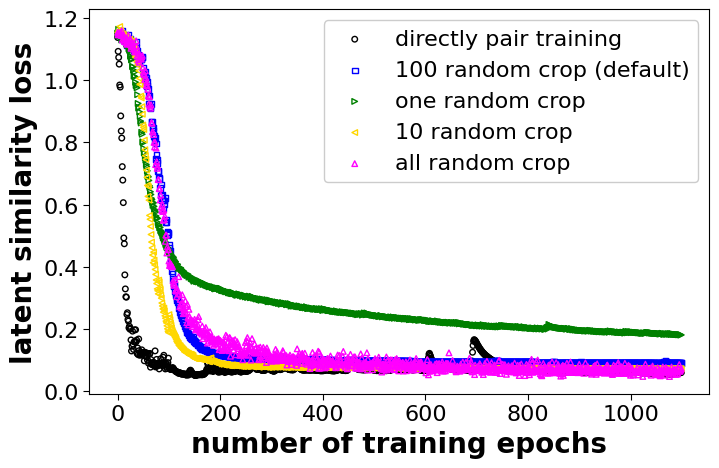

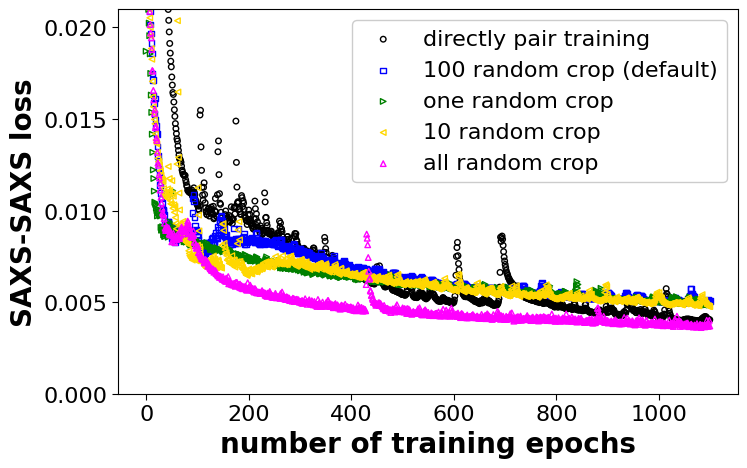

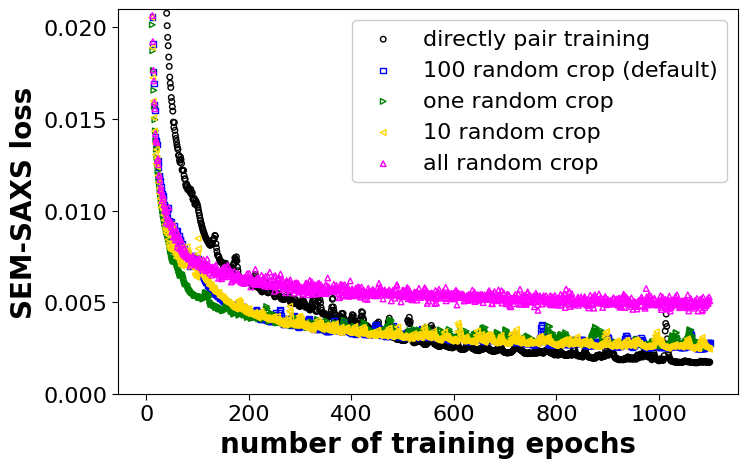

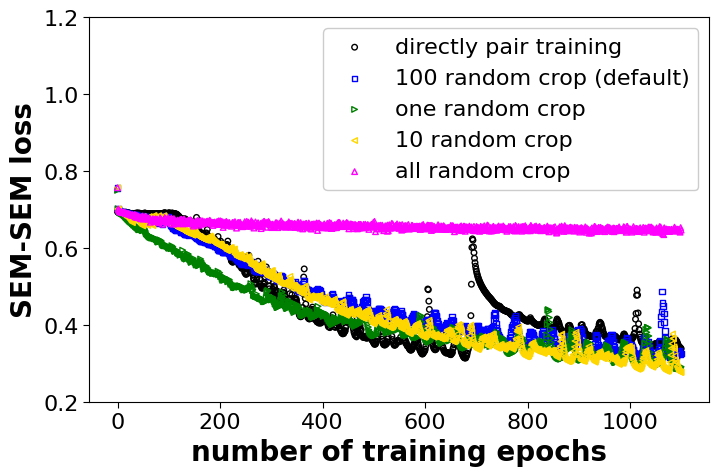

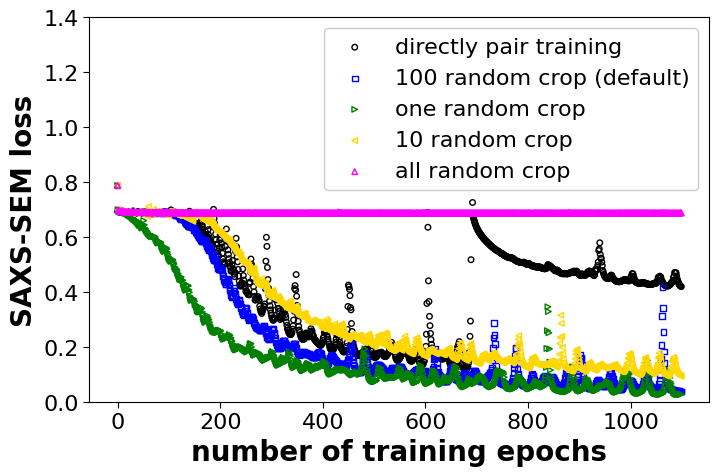

In [30]:
marker_size = 16

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[0]]['sim_loss'], marker='o', s=marker_size, edgecolors='k', facecolor='none', label='%s' % protocol_labels[0])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[1]]['sim_loss'], marker='s', s=marker_size, edgecolors='b', facecolor='none', label='%s' % protocol_labels[1])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[2]]['sim_loss'], marker='>', s=marker_size, edgecolors='g', facecolor='none', label='%s' % protocol_labels[2])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[3]]['sim_loss'], marker='<', s=marker_size, edgecolors='gold', facecolor='none', label='%s' % protocol_labels[3])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[4]]['sim_loss'], marker='^', s=marker_size, edgecolors='magenta', facecolor='none', label='%s' % protocol_labels[4])
ax.legend(fontsize=16, loc='upper right', framealpha=1)
ax.tick_params(labelsize=16, length=4)
ax.set_xlabel(r'number of training epochs', fontsize=20, fontweight='bold')
ax.set_ylabel(r'latent similarity loss', fontsize=20, fontweight='bold')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[0]]['saxs_saxs_loss'], marker='o', s=marker_size, edgecolors='k', facecolor='none', label='%s' % protocol_labels[0])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[1]]['saxs_saxs_loss'], marker='s', s=marker_size, edgecolors='b', facecolor='none', label='%s' % protocol_labels[1])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[2]]['saxs_saxs_loss'], marker='>', s=marker_size, edgecolors='g', facecolor='none', label='%s' % protocol_labels[2])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[3]]['saxs_saxs_loss'], marker='<', s=marker_size, edgecolors='gold', facecolor='none', label='%s' % protocol_labels[3])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[4]]['saxs_saxs_loss'], marker='^', s=marker_size, edgecolors='magenta', facecolor='none', label='%s' % protocol_labels[4])
ax.legend(fontsize=16, loc='upper right', framealpha=1)
ax.tick_params(labelsize=16, length=4)
ax.set_ylim(0, 0.021)
ax.set_xlabel(r'number of training epochs', fontsize=20, fontweight='bold')
ax.set_ylabel(r'SAXS-SAXS loss', fontsize=20, fontweight='bold')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[0]]['sem_saxs_loss'], marker='o', s=marker_size, edgecolors='k', facecolor='none', label='%s' % protocol_labels[0])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[1]]['sem_saxs_loss'], marker='s', s=marker_size, edgecolors='b', facecolor='none', label='%s' % protocol_labels[1])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[2]]['sem_saxs_loss'], marker='>', s=marker_size, edgecolors='g', facecolor='none', label='%s' % protocol_labels[2])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[3]]['sem_saxs_loss'], marker='<', s=marker_size, edgecolors='gold', facecolor='none', label='%s' % protocol_labels[3])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[4]]['sem_saxs_loss'], marker='^', s=marker_size, edgecolors='magenta', facecolor='none', label='%s' % protocol_labels[4])
ax.legend(fontsize=16, loc='upper right', framealpha=1)
ax.tick_params(labelsize=16, length=4)
ax.set_ylim(0, 0.021)
ax.set_xlabel(r'number of training epochs', fontsize=20, fontweight='bold')
ax.set_ylabel(r'SEM-SAXS loss', fontsize=20, fontweight='bold')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[0]]['sem_sem_loss'], marker='o', s=marker_size, edgecolors='k', facecolor='none', label='%s' % protocol_labels[0])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[1]]['sem_sem_loss'], marker='s', s=marker_size, edgecolors='b', facecolor='none', label='%s' % protocol_labels[1])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[2]]['sem_sem_loss'], marker='>', s=marker_size, edgecolors='g', facecolor='none', label='%s' % protocol_labels[2])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[3]]['sem_sem_loss'], marker='<', s=marker_size, edgecolors='gold', facecolor='none', label='%s' % protocol_labels[3])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[4]]['sem_sem_loss'], marker='^', s=marker_size, edgecolors='magenta', facecolor='none', label='%s' % protocol_labels[4])
ax.legend(fontsize=16, loc='upper right', framealpha=1)
ax.tick_params(labelsize=16, length=4)
ax.set_ylim(0.2, 1.2)
ax.set_xlabel(r'number of training epochs', fontsize=20, fontweight='bold')
ax.set_ylabel(r'SEM-SEM loss', fontsize=20, fontweight='bold')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[0]]['saxs_sem_loss'], marker='o', s=marker_size, edgecolors='k', facecolor='none', label='%s' % protocol_labels[0])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[1]]['saxs_sem_loss'], marker='s', s=marker_size, edgecolors='b', facecolor='none', label='%s' % protocol_labels[1])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[2]]['saxs_sem_loss'], marker='>', s=marker_size, edgecolors='g', facecolor='none', label='%s' % protocol_labels[2])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[3]]['saxs_sem_loss'], marker='<', s=marker_size, edgecolors='gold', facecolor='none', label='%s' % protocol_labels[3])
ax.scatter(pair_training_epochs, hyperparameter_tuning_result['%s' % protocol_labels[4]]['saxs_sem_loss'], marker='^', s=marker_size, edgecolors='magenta', facecolor='none', label='%s' % protocol_labels[4])
ax.legend(fontsize=16, loc='upper right', framealpha=1)
ax.tick_params(labelsize=16, length=4)
ax.set_ylim(0.0, 1.4)
ax.set_xlabel(r'number of training epochs', fontsize=20, fontweight='bold')
ax.set_ylabel(r'SAXS-SEM loss', fontsize=20, fontweight='bold')